# Including X-uncertainty in Curve Fit
***
Curve fit we use is based on the least-squares fitting method, which assumes that uncertain measurements (y) are taken at *certain*, chosen positions (x). Unfortunately this is not the case in physics experiments, so we need to find a way to account for the x-uncertainties. **A more detailed discussion of this method is in Taylor, p. 189**

### Brief Derivation
***

**(If you just want to look at the code example, jump ahead to the [code section](#code))**

<img src="../images/curvefit_xonly.png" style="float:left" width=300>
<br>
We have some data that we think follows a linear model:

$$ y(x) = A + B x $$

Our x-values are very uncertain, but our y-measurements are so precise the uncertainty is negligible (for example, LCR readings).

The x error means $x$ can be anywhere between $x = 0.15$ and $x=0.4$. This means that, assuming our model is correct, y can be anything from $y(0.15)$ and $y(0.40)$. We can calculate the difference between these two:

$$ \Delta y = y(0.40) - y(0.15) = B(0.40 - 0.15) = B \Delta x $$

So given the x-uncertainty, we can calculate ***the uncertainty in the prediction***, $\Delta y_{model}$.

<div style="clear:both"><br></div>
#### What if the model is more complicated?
<img src="../images/curvefit_xonly_curved.png" style="float:right" width=350>

Here, we think the data follows a quadratic:

$$ y(x) = x^2 $$

Although the x-uncertainties are constant, the effect of changing x within its uncertainties on the predicted y depends on what x is. If the slope is shallow, large change in x leads to a small change in y; and if the slope is steep, small change in x can lead to a large change in y. 

So, to convert the uncertainties, we need to **propagate error** to get the ***predicted y-error*** from measured x-error.

$$\Delta y_{emodel} = \frac{dy}{dx} \Delta x = 2 x \Delta x $$

<div style="clear:both"><br></div>
#### Including measured y uncertainties

Now we know how to convert x uncertainties into *predicted* y-uncertainties, based on our model. Final question is: what happens if we already have some y-uncertainties from the measurement? How do we add these two together?

<img src="../images/curvefit_yunc.png" style="float:left" width=400>

We treat them as separate uncertainties that need to be added!

On the plot on the left, the x and y uncertainties are $\Delta x$ and $\Delta y$. We can convert $\Delta x$ into an ***model*** y-uncertainty using error propagation:

$$ \Delta y_{model} = \frac{dy}{dx} \Delta x $$

Now, there are two sources of error for $y$: the uncertainty of the model due to some uncertainty in $x$, and the measurement uncertainty. We add them in **quadrature** since these are independent:

$$\Delta y_{final} = \sqrt{ \Delta y_{model}^2 + \Delta y } = \sqrt{ \Delta y^2 + \bigg( \frac{dy}{dx} \Delta x \bigg)^2} $$

#### Final Hurdle

We're all set now, right? Well, not quite. When you try to do this, you'll notice that to calculate $\Delta y_{model} $, you'll need to know exactly what the model is! For example: in a linear model, $y = A + Bx$, to figure out $dy/dx$ you'll need to know the slope, $B$.

There is no *easy* way to do this perfectly, without going into least squares fitting - but we can do a really good job with a simple trick.

1. First, calculate fit parametes using simple `curve_fit`, not including x-uncertainties. <br>
This will give us an *estimate* of the fit parameters. 


2. Using the *estimated* parameters, calculate the model uncertainties using error propagation. <br>
$\Delta y_{model} = (dy/dx) \Delta x$


3. Combine the model uncertainty with the measured y uncertainty to get the ***total*** y-error. <br>
$\Delta y_{total} = \sqrt{ \Delta y_{model}^2 + \Delta y^2 }$


4. Using `sigma=y_total` compute the better estimate for the fit parameters.


5. If you'd like, repeat steps 2-4 again, but one repeat should be enough!

## <span id="code">New curve-fit code</span>
***

First, import things, and produce our ~~fake~~ example set of data. <br>
The data will be quadratic: $y = 3x^2$, and we'll fit it with a second order polynomial: $y = Ax^2 + Bx + C$.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

# List of 10 x-values from 0 to 1
xs = np.linspace(0, 1.5, 10)

# What perfect measurements would be: y = 3x^2
ys_perfect = 3*xs**2

# Add some random noise now.
# Make 10 random values from 0 to 1
noise = np.random.rand(10)
# We want the average error to be 0, it's currently 0.5; so we subtract 0.5 from the noise
noise = noise - 0.5
# Scale the noise down a little so it varies from -0.1 to 0.1 rather than from -0.5 to 0.5
noise = noise/5

# Add the noise to our measurements. Also add a systematic error of 0.1 just for fun
ys = ys_perfect + noise + 0.1

# While taking the measurements, I decided my x-uncertainty is 0.1 and y-uncertainty is 0.05.
xerr = 0.1   * np.ones(10) # makes a list of 10 ones, and I multiply it by 0.1
yerr = 0.05  * np.ones(10)

Here is what our fake data looks like.

<ErrorbarContainer object of 3 artists>

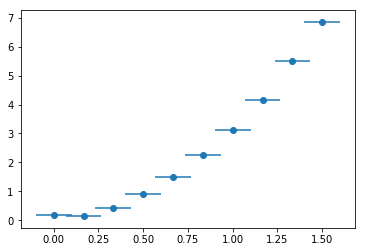

In [44]:
plt.errorbar(xs, ys, xerr=xerr, yerr=yerr, fmt="o")

As you can see, the y error is tiny, but the x error matters a lot. Let's fit a line to that using steps 1-5 from above!

In [45]:
###############################################################################################
# STEP 1: use simple curve_fit (no y uncertainties) to get an ESTIMATE of the fit parameters.

def quadratic(x, A, B, C):
    return A + B*x + C*x**2

# Initial guess: A=0, B=0, C=3 (y=3x^2)
p_est, cov_est = curve_fit(quadratic, xs, ys, sigma=yerr, absolute_sigma=True, p0=[0, 0, 3] )

A_est = p_est[0];    dA_est = np.sqrt(cov_est[0][0])
B_est = p_est[1];    dB_est = np.sqrt(cov_est[1][1])
C_est = p_est[2];    dC_est = np.sqrt(cov_est[2][2])

print("Initial estimate:\n A = %3.2f +/- %3.2f \n B = %3.2f +/- %3.2f \n C = %3.2f +/- %3.2f" % 
        (A_est, dA_est, B_est, dB_est, C_est, dC_est))

###############################################################################################
# STEP 2: Using the estimated parameters, calculate the model uncertainties using error propagation. 

# y = A + Bx + Cx^2 so dy/dx = B + 2Cx, so dy = (B+2Cx)dx
ymodel_err = (B_est + 2 * C_est * xs)*xerr

###############################################################################################
# STEP 3: Combine the model uncertainty with the measured y uncertainty to get the total y-error. 

ytotal_err = np.sqrt(yerr**2 + ymodel_err**2)

###############################################################################################
# STEP 4: Using sigma=ytotal_err compute the better estimate for the fit parameters.

# Initial guess: A=0, B=0, C=3 (y=3x^2)
p, cov = curve_fit(quadratic, xs, ys, sigma=ytotal_err, absolute_sigma=True, p0=[0, 0, 3] )

A = p[0];    dA = np.sqrt(cov[0][0])
B = p[1];    dB = np.sqrt(cov[1][1])
C = p[2];    dC = np.sqrt(cov[2][2])

print("\nAdjusted fit:\n A = %3.2f +/- %3.2f \n B = %3.2f +/- %3.2f \n C = %3.2f +/- %3.2f" % 
        (A, dA, B, dB, C, dC))

Initial estimate:
 A = 0.12 +/- 0.04 
 B = 0.03 +/- 0.12 
 C = 2.99 +/- 0.08

Adjusted fit:
 A = 0.17 +/- 0.05 
 B = -0.36 +/- 0.51 
 C = 3.29 +/- 0.50


We can compare the two fits on the plot:

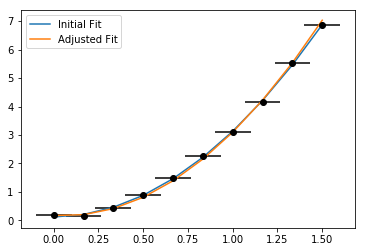

In [46]:
plt.errorbar(xs, ys, xerr=xerr, yerr=yerr, fmt="ko")

plt.plot(xs, quadratic(xs, A_est, B_est, C_est), "-", color="C0", label="Initial Fit")
plt.plot(xs, quadratic(xs, A, B, C), "-", color="C1", label="Adjusted Fit")
plt.legend()

As you can see **the fits are not very different** but the **uncertainties are much higher when x-errors are included**. These uncertainties are a lot more realistic. Even though this is not a real data set, we can still think which of these two fits makes sense. 

* The "perfect" data has A=0, B=0, C=3. In the initial fit, neither A, B or C were consistent with this. When we adjusted errors, B and C became consistent with the perfect model, and A is slightly inconsistent.
* I did add a systematic error of a constant offset = 0.1. The adjusted fit captures this well while the initial fit does not. 
* The "random error" I added had an amplitude of +/- 0.1, and the systematic error was similar to this, so we should expect our data to be consistent with the model. The adjusted one is, while the initial guess is not - so it greatly underestimates the uncertainty!

### Cheeky-fancy method for code nerds
***

If we want to uber-optimize this, we can write a recursive function that will iterate estimation/reevaluation until the model parameters and their uncertainties do not change significantly. I'm doing this for fun, so you should probably stop reading now :)

In [61]:
def quadratic(x, A, B, C):
    return A + B*x + C*x**2

# This is just the derivative of the model, dy/dx, for convenience
def derivative(x, B, C):
    return B + C*x

'''
This function takes in x/y data, passes it into curve fit, and looks at the parameters returned by curve_fit.
The function can also receive some previous parameter values. If it does, it checks if the percent difference
between the new and the old fit is less than some tolerance value, tol. 
'''
tol = 0.1
'''
If the difference is less than tolerance (acceptable), then a new iteration of curve_fit with readjusted parameters does not
improve the model much, so we just return the new values. If the difference > tol, re-calculate curve_fit again adjusting the
error.
'''
def get_params(x, y, xerr, yerr, old_params=None):
    
    # If this is the first time running get_params, we don't know the parameter estimate so old_params=None.
    # This block doesn't run, which means ymodel_err is not calculated.
    if old_params:
        
        # Read out the old parameters from the old_params dictionary that is passed to this function
        A  = old_params["A"];  B  = old_params["B"];  C  = old_params["C"]
        dA = old_params["dA"]; dB = old_params["dB"]; dC = old_params["dC"]

        y_modelerr = derivative(x, B, C)*xerr             # Step 2
        y_totalerr = np.sqrt( y_modelerr**2 + yerr**2 )   # Step 3
        
    else:
        # If this is the first estimate, total y-uncertainty is just the measured y-uncertainty
        y_totalerr = yerr
        
    # Step 1 or 4: run curve_fit
    p, cov = curve_fit(quadratic, xs, ys, sigma=y_totalerr, absolute_sigma=True, p0=[0, 0, 3] )
    
    # Make a dictionary new_params to store the new results of the curve_fit
    new_params = {"A" : p[0],   "dA" : np.sqrt(cov[0][0]),
                  "B" : p[1],   "dB" : np.sqrt(cov[1][1]),
                  "C" : p[2],   "dC" : np.sqrt(cov[2][2]) }
    
    # NEW STEP: Compare the new results to the old results. If the difference in any one parameter
    # exceeds the tolerance, run the get_params() function again, this time using new_params as the
    # initial old_params to get the uncertainty estimate.
    
    # By default, don't run the curve_fit again
    run_again=False
    if old_params:        
        for parameter in old_params:
            old = old_params[parameter]
            new = new_params[parameter]
            # Check if the % difference is bigger than the maximum tolerance. 
            # If so, set run_again=True and exit the loop. No point checking other parameters; re-run the curve fit/
            if abs( (new-old)/old ) > tol:
                run_again = True
                break
    else:
        # If the old parameters are not given, this is the first estimate, so run again by default.
        run_again = True
    
    if run_again:
        # If run_again was set to true in the loop above, re-run the whole function recursively.
        # I use print statements to see how many iterations it took.
        print("Running the estimate again")
        get_params(x, y, xerr, yerr, old_params=new_params)

    # Eventually, after some iterations of this function, the % difference between old and new fits will be small
    # so the function will leave the recursive part and be able to return the fit parameters.
    return new_params

In [62]:
get_params(xs, ys, xerr, yerr)

Running the estimate again
Running the estimate again


{'A': 0.1193325701591244,
 'dA': 0.039312262014389435,
 'B': 0.027571359947897812,
 'dB': 0.1220562134158681,
 'C': 2.985329828282323,
 'dC': 0.07833494278001249}

Awesome! That worked! A day not wasted